<a href="https://colab.research.google.com/github/casparhsws/alt-signals/blob/main/news_sentiment_longshort_vxrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## News Sentiment Based Long-Short Trading Strategy - Vaxart Inc (NASDAQ:VXRT)

###### Load dependency libraries 

In [1]:
!pip install feedparser
!pip install textblob
!pip install arrow
!pip3 install yfinance --upgrade --no-cache-dir
!pip install vaderSentiment
import yfinance as yf
import pandas as pd
import numpy as np
import feedparser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 81kB 7.3MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-cp36-none-any.whl size=6067 sha256=f6927ff72ed003d57d72a4bb20096e54ccef951bd3b8c85d480be951c5f098c8
  Stored in directory: /root/.cache/pip/wheels/f1/80/5a/444ba08a550cdd241bd9baf8bae44be750efe370adb944506a
Successfully built sgmllib3k
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 5.5MB 14.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=ccd4a5ae5bd37c41c43bc0165d36ad8baa7a41f5ea604d2c2e82943d67e1968c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6hxtvhoq/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 133kB 12.5MB/s 


**News Sentiment Trading - Long / Short**

**Pipeline:**
1. **Fetch news** - read in news source via an RSS feed (Feedparser)
2. **Assign sentiment score** - assign sentiment score (Vader and TextBlob)
6. **Historical EOD prices** - fetch historical prices (Yfinance)
6. **Backtesting - Calculate PnL** - back test for PnL performance

**Strategy:**
* **Positive News Sentiment** - if market opens on positive news, short the stock from market open to market close 
* **Negative News Sentiment** - if market opens on negative news, go long - buy on open, sell on close

See more at:
*   https://www.altsignals.ai







### **1. Fetch News from RSS Feed**

In [15]:
from bs4 import BeautifulSoup

def clean_text(raw_html):
  cleantext = BeautifulSoup(raw_html, "lxml").text
  return cleantext

symbol = 'VXRT'
company = 'Vaxart Inc'
rss_url = 'https://www.globenewswire.com/RssFeed/Organization/dqKTlO0WKWyA0lN-FU6zhA=='
cols = ['ticker', 'company', 'title', 'summary', 'published', 'link', 'sentiment', 'shares', 'price_sensi', 'begin_price', 'end_price', 'side', 'cumpnl', 'pnl', 'strategy']

news_df = pd.DataFrame(columns = cols)
feed = feedparser.parse(rss_url )

for newsitem in feed['items']:
    news_df = news_df.append({'title': newsitem['title'], 
                      'summary': clean_text(newsitem['summary']), 
                      'published': newsitem['published'], 
                      'link': newsitem['link']}, ignore_index=True)
news_df['ticker'] = symbol
news_df['company'] = company
news_df.head()

,ticker,company,title,summary,published,link,sentiment,shares,price_sensi,begin_price,end_price,side,cumpnl,pnl,strategy
0,VXRT,Vaxart Inc,Vaxart Hosting Key Opinion Leader Panel Call f...,Title: An Oral Tablet Vaccine – A Potential Gl...,"Mon, 16 Nov 2020 13:30 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,VXRT,Vaxart Inc,Vaxart Announces Presentations at the Jefferie...,"SOUTH SAN FRANCISCO, Calif., Nov. 16, 2020 (...","Mon, 16 Nov 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VXRT,Vaxart Inc,Vaxart Reports Third Quarter 2020 Financial Re...,Enrollment in Phase 1 for Oral COVID-19 Vaccin...,"Thu, 12 Nov 2020 21:01 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VXRT,Vaxart Inc,Vaxart Announces Additional Data from Hamster ...,Robust Immune Response and Significantly Reduc...,"Thu, 12 Nov 2020 13:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,VXRT,Vaxart Inc,Vaxart Announces Positive Hamster Challenge St...,Vaccinated Hamsters Show Protection from COVID...,"Wed, 14 Oct 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **2. Assign Sentiment Score**

In [16]:
from textblob import TextBlob

# Sentiment score from TextBlob
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Sentiment score from Vader
def get_vader_sentiment(txt):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(txt)
    return vs['compound']

news_df['sentiment'] = news_df['summary'].apply(lambda x : (get_vader_sentiment(x) + get_textblob_sentiment(x))/2)
news_df.head()

,ticker,company,title,summary,published,link,sentiment,shares,price_sensi,begin_price,end_price,side,cumpnl,pnl,strategy
0,VXRT,Vaxart Inc,Vaxart Hosting Key Opinion Leader Panel Call f...,Title: An Oral Tablet Vaccine – A Potential Gl...,"Mon, 16 Nov 2020 13:30 GMT",http://www.globenewswire.com/news-release/2020...,0.1591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,VXRT,Vaxart Inc,Vaxart Announces Presentations at the Jefferie...,"SOUTH SAN FRANCISCO, Calif., Nov. 16, 2020 (...","Mon, 16 Nov 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.1591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VXRT,Vaxart Inc,Vaxart Reports Third Quarter 2020 Financial Re...,Enrollment in Phase 1 for Oral COVID-19 Vaccin...,"Thu, 12 Nov 2020 21:01 GMT",http://www.globenewswire.com/news-release/2020...,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VXRT,Vaxart Inc,Vaxart Announces Additional Data from Hamster ...,Robust Immune Response and Significantly Reduc...,"Thu, 12 Nov 2020 13:00 GMT",http://www.globenewswire.com/news-release/2020...,0.5885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,VXRT,Vaxart Inc,Vaxart Announces Positive Hamster Challenge St...,Vaccinated Hamsters Show Protection from COVID...,"Wed, 14 Oct 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
[(get_vader_sentiment(s),s) for s in list(news_df.summary)]


[(0.3182,
  'Title: An Oral Tablet Vaccine – A Potential Global Solution to COVID-19 and Norovirus'),
 (0.3182,
  'SOUTH SAN FRANCISCO, Calif., Nov.  16, 2020  (GLOBE NEWSWIRE) -- Vaxart, Inc., (NASDAQ: VXRT), a clinical-stage biotechnology company developing oral vaccines that are administered by tablet rather than by injection, announced\xa0today that management will be participating in two upcoming virtual investor conferences and invites investors to participate by webcast. Please see additional details below:'),
 (0.0, 'Enrollment in Phase 1 for Oral COVID-19 Vaccine Trial Completed'),
 (0.802,
  'Robust Immune Response and Significantly Reduce Viral Load Robust Immune Response and Significantly Reduce Viral Load'),
 (0.0,
  'Vaccinated Hamsters Show Protection from COVID-19 based on Prespecified Indicators of Clinical Outcomes Vaccinated Hamsters Show Protection from COVID-19 based on Prespecified Indicators of Clinical Outcomes'),
 (0.4215,
  'Open-label, dose ranging study to e

### **3. Get Historical Price Data**

In [17]:
# An amazing library by Ran Roussi -  https://github.com/ranaroussi/yfinance, https://aroussi.com/post/python-yahoo-finance
import yfinance as yf
company_financials = yf.Ticker( symbol )
prices_df = company_financials.history(period='max')
prices_df.sort_values(by = 'Date', ascending = False, inplace = True)
prices_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-25,6.855,6.84,6.30,6.388,6953598,0.0,0.0
2020-11-24,6.860,6.94,6.15,6.260,11332900,0.0,0.0
2020-11-23,6.610,7.13,6.01,7.120,12802000,0.0,0.0
2020-11-20,5.900,6.55,5.86,6.400,12219700,0.0,0.0
2020-11-19,5.890,5.96,5.64,5.910,9228500,0.0,0.0


In [117]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime


fig = go.Figure(data=[go.Candlestick(x=prices_df.reset_index()['Date'],
                open=prices_df['Open'],
                high=prices_df['High'],
                low=prices_df['Low'],
                close=prices_df['Close'])])

fig.show()

In [101]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime


fig = go.Figure(data=[go.Candlestick(x=sent_price.reset_index()['index'],
                open=sent_price['Open'],
                high=sent_price['High'],
                low=sent_price['Low'],
                close=sent_price['Close'])])

fig.show()

In [115]:
# x and y given as DataFrame columns
import plotly.express as px
df = sent_price.reset_index()
fig = px.scatter(df, x="long_short", y="sentiment",hover_data=['index'])
fig.show()


In [27]:
news_df['date'] = news_df.published.apply(lambda x: pd.to_datetime(parse(str(x))))

In [34]:
day_sent = news_df.groupby(news_df.date.dt.date).mean()['sentiment']
day_sent

date
2020-06-03    0.000000
2020-06-15    0.000000
2020-06-23    0.068182
2020-06-24    0.538350
2020-06-25    0.250000
2020-06-26    0.125000
2020-07-13    0.470100
2020-07-16   -0.031250
2020-08-06    0.106061
2020-08-10    0.068182
2020-08-27    0.250000
2020-09-03    0.000000
2020-09-08    0.388350
2020-09-14   -0.050000
2020-10-13    0.210750
2020-10-14    0.000000
2020-11-12    0.294250
2020-11-16    0.159100
Name: sentiment, dtype: float64

In [48]:
sent_price = pd.concat([prices_df, day_sent], axis=1).dropna(subset=['sentiment'])
sent_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits,sentiment
2020-06-03,2.91,2.91,2.65,2.74,5289300,0.0,0.0,0.000000
2020-06-15,2.26,2.48,2.26,2.46,2846600,0.0,0.0,0.000000
2020-06-23,2.70,2.70,2.58,2.66,2418300,0.0,0.0,0.068182
2020-06-24,2.62,3.37,2.61,3.19,19402200,0.0,0.0,0.538350
2020-06-25,3.61,6.48,3.45,6.26,141914900,0.0,0.0,0.250000
2020-06-26,11.49,14.30,7.89,8.04,230619000,0.0,0.0,0.125000
2020-07-13,9.02,13.53,8.56,12.12,134329000,0.0,0.0,0.470100
2020-07-16,14.09,17.15,14.00,15.63,56496000,0.0,0.0,-0.031250
2020-08-06,9.86,10.04,9.04,9.10,11934900,0.0,0.0,0.106061
2020-08-10,9.61,9.86,9.27,9.40,12351600,0.0,0.0,0.068182


In [112]:
sent_price['hi-low'] = sent_price.High - sent_price.Low

In [87]:
sent_price = sent_price.assign(
    prev_sent= lambda x: x.sentiment.shift(1),
)
sent_price['long_short'] = sent_price.apply(lambda x: x.Open / x.Close if x.prev_sent < 0 else x.Close / x.Open, axis=1)

In [88]:
sent_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits,sentiment,long_short,prev_sent
2020-06-03,2.91,2.91,2.65,2.74,5289300,0.0,0.0,0.000000,0.941581,NaN
2020-06-15,2.26,2.48,2.26,2.46,2846600,0.0,0.0,0.000000,1.088496,0.000000
2020-06-23,2.70,2.70,2.58,2.66,2418300,0.0,0.0,0.068182,0.985185,0.000000
2020-06-24,2.62,3.37,2.61,3.19,19402200,0.0,0.0,0.538350,1.217557,0.068182
2020-06-25,3.61,6.48,3.45,6.26,141914900,0.0,0.0,0.250000,1.734072,0.538350
2020-06-26,11.49,14.30,7.89,8.04,230619000,0.0,0.0,0.125000,0.699739,0.250000
2020-07-13,9.02,13.53,8.56,12.12,134329000,0.0,0.0,0.470100,1.343681,0.125000
2020-07-16,14.09,17.15,14.00,15.63,56496000,0.0,0.0,-0.031250,1.109297,0.470100
2020-08-06,9.86,10.04,9.04,9.10,11934900,0.0,0.0,0.106061,1.083516,-0.031250
2020-08-10,9.61,9.86,9.27,9.40,12351600,0.0,0.0,0.068182,0.978148,0.106061


In [ ]:
sent_price = sent_price.assign(
    prev_sent= lambda x: x.sentiment.shift(1),
)
sent_price['long_short'] = sent_price.apply(lambda x: x.Open / x.Close if x.prev_sent < 0 else x.Close / x.Open, axis=1)

In [89]:
sent_price.long_short.cumprod()

2020-06-03    0.941581
2020-06-15    1.024906
2020-06-23    1.009723
2020-06-24    1.229395
2020-06-25    2.131860
2020-06-26    1.491745
2020-07-13    2.004429
2020-07-16    2.223508
2020-08-06    2.409208
2020-08-10    2.356561
2020-08-27    2.245874
2020-09-03    2.224485
2020-09-08    1.935382
2020-09-14    2.360074
2020-10-13    2.280072
2020-10-14    2.067345
2020-11-12    2.115145
2020-11-16    2.424147
Name: long_short, dtype: float64

In [91]:
sent_price.apply(lambda x: x.Close / x.Open, axis=1).cumprod()

2020-06-03    0.941581
2020-06-15    1.024906
2020-06-23    1.009723
2020-06-24    1.229395
2020-06-25    2.131860
2020-06-26    1.491745
2020-07-13    2.004429
2020-07-16    2.223508
2020-08-06    2.052122
2020-08-10    2.007279
2020-08-27    1.912998
2020-09-03    1.894779
2020-09-08    1.648526
2020-09-14    2.010271
2020-10-13    2.080807
2020-10-14    1.886672
2020-11-12    1.930294
2020-11-16    2.212292
dtype: float64

### **5. Backtesting - Calculate PnL for Long Short Strategy**

In [18]:
import arrow
from dateutil.parser import parse

def format_date(published):
    arrow_date = arrow.get(published)
    return arrow_date.format('YYYY-MM-DD')

def get_price(price_series):
    return price_series.iloc[0]

def get_previous_bday(published):
    ts = pd.Timestamp(published) 
    bd = pd.tseries.offsets.BusinessDay(n = 1)
    return ts - bd 

capital = 10000
strategy = 'longshort'

shares_list = []
ticker_list = []
company_list = []
pnl_list = []
begin_price_list = []
end_price_list = []
side_list = []


def get_begin_price(published):
    arrow_start = arrow.get(published)
    start_date = format_date(arrow_start)
    return get_price(prices_df.loc[start_date]['Open'])

def get_end_price(published):
    end_date = format_date(published)
    return get_price(prices_df.loc[end_date]['Close']) 

def get_shares(capital, begin_price):
    return capital / begin_price

def get_pnl(published, side):
    side_list.append(side)
    begin_price = get_begin_price(published)
    begin_price_list.append(begin_price)
    end_price = get_end_price(published)
    end_price_list.append(end_price)
    shares = get_shares(capital, begin_price)
    shares_list.append(shares)
    pnl = (end_price - begin_price) * shares
    
    if (side == 'long'):
        pnl = pnl * 1
    else:
        pnl = pnl * -1
        
    pnl_list.append(pnl)

In [19]:
# if sentiment was positive on market open, we go short. Otherwise go go long

for i, row in news_df.iterrows():
  if row['sentiment'] > 0:
    get_pnl(parse(row['published']), side='long')
  else:
    get_pnl(parse(row['published']), side='short')
 

In [20]:
# set constant values
news_df['ticker'] = symbol
news_df['company'] = company
news_df['strategy'] = strategy

# add additional dynamic columns
news_df['shares'] = shares_list
news_df['pnl'] = pnl_list
news_df['cumpnl'] = news_df['pnl'].cumsum() + capital
news_df['begin_price'] = begin_price_list
news_df['end_price'] = end_price_list
news_df['side'] = side_list
news_df


,ticker,company,title,summary,published,link,sentiment,shares,price_sensi,begin_price,end_price,side,cumpnl,pnl,strategy
0,VXRT,Vaxart Inc,Vaxart Hosting Key Opinion Leader Panel Call f...,Title: An Oral Tablet Vaccine – A Potential Gl...,"Mon, 16 Nov 2020 13:30 GMT",http://www.globenewswire.com/news-release/2020...,0.159100,2057.613112,NaN,4.86,5.57,long,11460.905388,1460.905388,longshort
1,VXRT,Vaxart Inc,Vaxart Announces Presentations at the Jefferie...,"SOUTH SAN FRANCISCO, Calif., Nov. 16, 2020 (...","Mon, 16 Nov 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.159100,2057.613112,NaN,4.86,5.57,long,12921.810776,1460.905388,longshort
2,VXRT,Vaxart Inc,Vaxart Reports Third Quarter 2020 Financial Re...,Enrollment in Phase 1 for Oral COVID-19 Vaccin...,"Thu, 12 Nov 2020 21:01 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,1926.782252,NaN,5.19,5.31,short,12690.597127,-231.213650,longshort
3,VXRT,Vaxart Inc,Vaxart Announces Additional Data from Hamster ...,Robust Immune Response and Significantly Reduc...,"Thu, 12 Nov 2020 13:00 GMT",http://www.globenewswire.com/news-release/2020...,0.588500,1926.782252,NaN,5.19,5.31,long,12921.810776,231.213650,longshort
4,VXRT,Vaxart Inc,Vaxart Announces Positive Hamster Challenge St...,Vaccinated Hamsters Show Protection from COVID...,"Wed, 14 Oct 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,1314.060424,NaN,7.61,6.90,short,13854.793727,932.982951,longshort
5,VXRT,Vaxart Inc,Vaxart Announces Dosing First Subject in Phase...,"Open-label, dose ranging study to examine safe...","Tue, 13 Oct 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.210750,1349.527693,NaN,7.41,7.67,long,14205.671236,350.877509,longshort
6,VXRT,Vaxart Inc,Vaxart Announces FDA Clearance of IND Applicat...,Recruitment for Phase 1 clinical study expecte...,"Mon, 14 Sep 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,-0.050000,1567.398091,NaN,6.38,7.78,short,12011.313759,-2194.357477,longshort
7,VXRT,Vaxart Inc,Vaxart’s Oral COVID-19 Vaccine Candidate Induc...,Triggering mucosal immunity may be crucial for...,"Tue, 08 Sep 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.388350,1805.054164,NaN,5.54,4.82,long,10711.675140,-1299.638619,longshort
8,VXRT,Vaxart Inc,"Vaxart, Inc. to Participate in September Virtu...",- H.C. Wainwright: 22nd Annual Global Investme...,"Thu, 03 Sep 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,1904.761905,NaN,5.25,5.20,short,10806.913599,95.238459,longshort
9,VXRT,Vaxart Inc,Vaxart Appoints Karen J. Wilson to its Board o...,"SOUTH SAN FRANCISCO, Calif., Aug. 27, 2020 (...","Thu, 27 Aug 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.250000,1515.151537,NaN,6.60,6.29,long,10337.216709,-469.696890,longshort


In [8]:
# same day news trading

cum_pnl = news_df['pnl'].sum()
cum_return = cum_pnl / capital * 100
print('Cumulative pnl (USD):', cum_pnl)
print('Cumulative return (%) 121 days):', cum_return)
print('Cumulative pnl and return (%) annualised:', 365/121 * cum_return) 

Cumulative pnl (USD): 7756.508989821238
Cumulative return (%) 121 days): 77.56508989821238
Cumulative pnl and return (%) annualised: 233.9773372962605


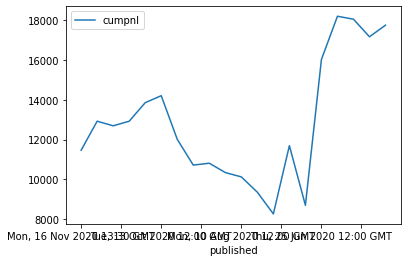

In [10]:
import matplotlib.pyplot as plt
news_df.plot(x="published", y=["cumpnl"])

**Resources**

* [AltSignals.AI](https://www.altsignals.ai/)
* [Yfinance](https://pypi.org/project/yfinance/)
* [TextBlob](https://pypi.org/project/textblob/)
* [Vader Sentiment](https://pypi.org/project/vaderSentiment/)

